# Twitter Sentiment Analysis

The dataset used is "Sentiment140" which can be accessed at the following link"
> https://www.kaggle.com/kazanova/sentiment140

The architecture used for sentiment analysis is "Word Embeddings" whose guide can be viewed at the following link:
>https://www.tensorflow.org/text/guide/word_embeddings

## Creating classes



In [1]:
class Sentiment:
    Negative = "Negative"
    Positive = "Positive"


class Tweet:
    def __init__(self, text, score):
        self.text = text
        self.score = score
        self.sentiment = self.get_sentiment()
        
    def get_sentiment(self):
        if self.score == 0:
            return Sentiment.Negative
        elif self.score == 4:
            return Sentiment.Positive
    
    
class TweetMethods:
    def __init__(self, Tweet):
        self.tweet = tweet
    
    def get_tweet(self):
        return [x.tweet for x in self.tweet]
    
    def get_sentiment(self):
        return [x.sentiment for x in self.tweet]
        

## Imports

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

2022-02-16 12:15:17.080327: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-02-16 12:15:17.080360: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Data

Labels for our columns were given at its Kaggle repository

In [3]:
COL_LABELS = ['Target', 'Id', 'Date', 'Flag', 'User', 'Text']
DATASET_ENC = 'ISO-8859-1'

In [4]:
# Loading our sentiment140 dataset
df = pd.read_csv("../data/1.6m_tweets.csv", encoding = DATASET_ENC, names = COL_LABELS, usecols = [0, 5])

## Examining our Data

In [5]:
df

,Target,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,4,Just woke up. Having no school is the best fee...
1599996,4,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,Happy 38th Birthday to my boo of alll time!!! ...


In [6]:
tweet_1 = Tweet(df['Text'][1599995], df['Target'][1599995])
print(tweet_1.text)
print(tweet_1.sentiment)

tweet_1 = Tweet(df['Text'][0], df['Target'][0])
print(tweet_1.text)
print(tweet_1.sentiment)

Just woke up. Having no school is the best feeling ever 
Positive
@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D
Negative


### Checking whether our data has any unlabelled entry and how many unique values are there for our sentiment analysis

In [16]:
print(f'Number of unlabelled entries in our data: {np.sum(df.isnull().any(axis=1))}')
print(f'Number of unqiue targets(scores) for our text data: {df["Target"].nunique()}')

Number of unlabelled entries in our data: 0
Number of unqiue targets(scores) for our text data: 2


<AxesSubplot:xlabel='Target', ylabel='count'>

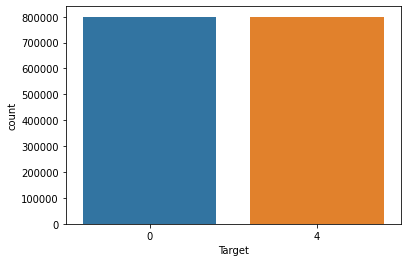

In [11]:
import seaborn as sns
sns.countplot(x='Target', data=df)

#### Conclusion
- There are no empty sets
- Only two sentiments are present: Positive and Negative
- Our data is evenly distributed

## Data Pre-processing
